In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
sns.set()

In [2]:
# 50 pages of data scraped, 1000 observations
raw_data = pd.read_csv('StanoviBGD-2021-02-10.csv')
raw_data.head()

,Unnamed: 0,Address,Size,Rooms,Floor,Total floors,Price (eur),Price per m2 (eur/m2),Type,Date,Advertiser
0,0,Beograd Opština Stari grad Centar Simina,27,1.5,I,4.0,92000,3407,Premium,10.02.2021.,Agencija
1,1,Beograd Opština Vračar Cvetni trg Resavska,113,4.5,V,6.0,290000,2566,Premium,07.02.2021.,Agencija
2,2,Beograd Opština Čukarica Čukarička padina Stev...,28,1.0,III,7.0,54900,1961,Premium,10.02.2021.,Agencija
3,3,Beograd Opština Palilula Karaburma Kamčatska,31,0.5,I,5.0,47000,1516,Premium,10.02.2021.,Agencija
4,4,Beograd Opština Vračar Crveni krst Starca Vuja...,51,2.5,III,4.0,102900,2018,Premium,10.02.2021.,Agencija


In [3]:
# Removing excess data
# We certanily won't use address or Index in this instance, it might be interesting to try something with Geo Coding in the future
# Price per m2 in combination with size will distort regression model
# Since the data is sourced from recent scraping, it shouldn't be important
# Size and Number of rooms are expected to corelate 
data = raw_data.drop(['Address','Unnamed: 0', 'Price per m2 (eur/m2)', 'Date', 'Rooms'],axis = 1)

In [4]:
# Checking for null values
data.isnull().sum() 

Size             0
Floor           66
Total floors    66
Price (eur)      0
Type             0
Advertiser       0
dtype: int64

In [5]:
# Since there are not that many cases I' ve decided to simplyremove them
data = data.dropna()

In [6]:
# Detecting otliers
data.describe()

,Size,Total floors,Price (eur)
count,934.000000,934.000000,934.000000
mean,553.663812,6.173448,150661.293362
std,1963.294362,3.765913,95436.225309
min,1.000000,1.000000,1299.000000
25%,51.000000,4.000000,89000.000000
50%,67.000000,5.000000,126500.000000
75%,95.750000,7.000000,183000.000000
max,14996.000000,30.000000,950000.000000


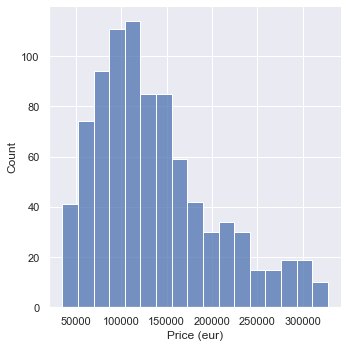

In [7]:
# Removing outliers for price, since there were not that many I' ve decided to trimp top 5 and bottom 1 percentile
qpmax = data['Price (eur)'].quantile(0.95)
qpmin = data['Price (eur)'].quantile(0.01)
data2 = data[data['Price (eur)'].between(qpmin, qpmax)]
sns.displot(data2['Price (eur)'])

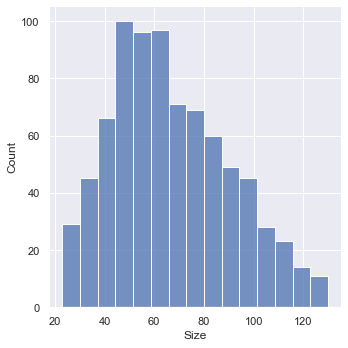

In [8]:
# Size had much more outliers, thus after some testing I removed top 9 percentiles and bottom 0.1
qsmax = data2['Size'].quantile(0.91)
qsmin = data2['Size'].quantile(0.001)
data_cleaned = data2[data2['Size'].between(qsmin, qsmax)]
sns.displot(data_cleaned['Size'])

In [9]:
# After data cleaning, we ended up with about 80% of the originial data
# Data is still a bit skewed, but I think that shouldnt pose a problem
data_cleaned.describe()

,Size,Total floors,Price (eur)
count,803.000000,803.000000,803.000000
mean,66.953923,6.190535,135080.114570
std,23.847638,3.721584,64672.583659
min,23.000000,1.000000,35000.000000
25%,50.000000,4.000000,88000.000000
50%,63.000000,5.000000,120000.000000
75%,84.500000,7.000000,168000.000000
max,130.000000,30.000000,325000.000000


In [10]:
# Transforming categorical data
# With Advertiser and Type, the case is straight forward
# For Advertiser I treated Investitor and Owner as same category, since they are not that well represented in this database
# Maybe we should try something with sampling?
# In our sample we didn't have any of 'Standard' advertisements, and those were only types
data_transformed = data_cleaned.copy()
data_transformed['Advertiser'] = data_transformed['Advertiser'].map({'Investitor': 0 ,'Vlasnik': 0, 'Agencija':1})
data_transformed['Type'] = data_transformed['Type'].map({'Premium': 0, 'Top': 1})

In [11]:
# Values for floors were given in Roman alphabet, with some codes
# I have decided to transform PR and SUT (Prizemlje - ground floor, Suteren basement?) as Floor 0
# VPR (visoko prizemlje - higher ground floor) as Floor 1
# and other rooman floors accordingly.
data_transformed['Floor'].unique()

array(['I', 'V', 'III', 'X', 'IV', 'II', 'VIII', 'VI', 'VPR', 'VII', 'PR',
       'XII', 'IX', 'XV', 'XI', 'XIII', 'XVI', 'SUT', 'XVII', 'XIV'],
      dtype=object)

In [12]:
# Quick function to transform roman to arabic numbers, prone to errors, doesn't check if proper roman numbers are used
def to_arabic(r_nr):
    roman_pairs = {'I': 1, 'V': 5, 'X': 10, 'L': 50}
    r_nr = r_nr.upper()
    total = roman_pairs[r_nr[0]] # 1st character transformed into arabic
    if len(r_nr) == 1:
        return total
    else:
        for i in range(1, len(r_nr)): #Ignoring first case..
            nr = roman_pairs[r_nr[i]]
            if r_nr[i] <= r_nr[i-1]:
                total += nr
            else:
                total -= nr
        return abs(total) # Abs because it will calculate IV as -4 and IX as -9...

In [13]:
# Hard coding non roman values and then appending roman ones
value_pairs = {'PR':0, 'SUT': 0, 'VPR': 1} 
for num in data_transformed['Floor'].unique():
    try:
        value_pairs[num] =(to_arabic(num))
    except:
        pass    
data_transformed['Floor'] = data_transformed['Floor'].map(value_pairs)

In [14]:
# Finally regression
# Test train split

y = data_transformed['Price (eur)']
X = data_transformed.drop('Price (eur)', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 70)
reg = LinearRegression().fit(X_train, y_train)


In [15]:
# 64% of price on test data is explained by our model
reg.score(X_test, y_test) 

0.6427033015593593

In [16]:
# Regression table
# Summary: 'Top' appartments are on average cheaper than 'Premium'
# Agency is selling on average for more then investitor or owner
# Should be further examined
reg_table = pd.DataFrame(X.columns.values, columns = ['Features'])
reg_table['Weights'] = reg.coef_
reg_table

,Features,Weights
0,Size,2131.479803
1,Floor,-1234.189153
2,Total floors,1712.390489
3,Type,-17322.159368
4,Advertiser,12039.577562


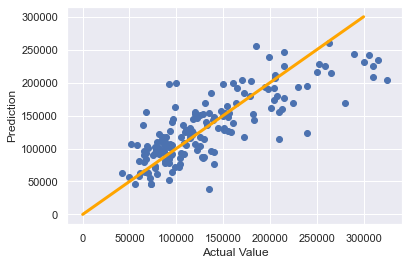

In [17]:
# Predictions plot initial impression: model underestimates prices when they are higher
y_hat_test = reg.predict(X_test)
plt.scatter(y_test, y_hat_test)
plt.xlabel('Actual Value')
plt.ylabel('Prediction')
plt.plot([0,300000],[0,300000], color = 'orange', linewidth = 3)
plt.show()

In [18]:
# Error summary table:
err = pd.DataFrame((y_hat_test), columns = ['Prediction'])
err['Targets'] = y_test.reset_index(drop=True)
err['Residual'] = abs(err['Prediction'] - err['Targets'])
err['Difference%'] = err['Residual']/err['Targets']*100
err.describe()

,Prediction,Targets,Residual,Difference%
count,161.000000,161.000000,161.000000,161.000000
mean,132351.974367,135251.080745,28588.408923,23.122946
std,51789.413182,64423.329251,25700.323067,21.859592
min,39181.647902,42000.000000,263.213447,0.200461
25%,93554.063753,88000.000000,9504.823377,8.171883
50%,124080.862715,118000.000000,23651.648557,18.493653
75%,164542.945727,165000.000000,39620.798878,31.612028
max,260251.656453,325000.000000,121741.050836,128.106280
